In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
import collections
from torch.utils.data import Dataset
from tqdm import tqdm


In [3]:
class ColorTypeDataset(Dataset):
    def __init__(self, path, label_map, transform=None):
        self.samples = []
        self.label_map = label_map
        self.transform = transform

        for label_name, label_id in label_map.items():
            folder = os.path.join(path, label_name)
            if not os.path.isdir(folder):
                continue
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(folder, filename), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [54]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

label_map = {
    'autumn': 0,
    'spring': 1,
    'summer': 2,
    'winter': 3
}

In [90]:
batch_size = 32

In [76]:
train_dataset = ColorTypeDataset('faces_cleaned_only/', label_map, transform=train_transform)
val_dataset = ColorTypeDataset('colortypes_cleaned_back/', label_map, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [62]:
from collections import Counter
import matplotlib.pyplot as plt

train_labels = [label for _, label in train_dataset]
train_counts = Counter(train_labels)

id_to_label = {v: k for k, v in label_map.items()}

print("Train class distribution:")
for label_id, count in train_counts.items():
    print(f"{id_to_label[label_id]}: {1/count}")


Train class distribution:
autumn: 0.0025380710659898475
spring: 0.004784688995215311
summer: 0.004651162790697674
winter: 0.0025575447570332483


In [103]:
num_classes = 4
epochs = 40
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

# === Loss, optimizer, scheduler ===
weights = torch.tensor([0.00253, 0.0047, 0.0046, 0.00256], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# === Training loop with early stopping ===
best_val_loss = 10**10
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Validation phase ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

            pred_labels = preds.argmax(dim=1)
            val_correct += (pred_labels == yb).sum().item()
            val_total += len(xb)

    val_accuracy = val_correct / val_total * 100
    scheduler.step(val_accuracy)

    print(f"Epoch {epoch+1}: Val Accuracy = {val_accuracy:.2f}%, Train Loss = {total_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Validation loss improved. Model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


100%|██████████| 38/38 [00:03<00:00, 10.71it/s]


Epoch 1: Val Accuracy = 26.55%, Train Loss = 153.7904, LR = 0.050000
Validation loss improved. Model saved.


100%|██████████| 38/38 [00:03<00:00, 10.66it/s]


Epoch 2: Val Accuracy = 44.00%, Train Loss = 52.7226, LR = 0.050000
Validation loss improved. Model saved.


100%|██████████| 38/38 [00:03<00:00, 10.65it/s]


Epoch 3: Val Accuracy = 45.09%, Train Loss = 44.3163, LR = 0.050000
Validation loss improved. Model saved.


100%|██████████| 38/38 [00:03<00:00, 10.61it/s]


Epoch 4: Val Accuracy = 45.82%, Train Loss = 41.7971, LR = 0.050000


100%|██████████| 38/38 [00:03<00:00, 10.61it/s]


Epoch 5: Val Accuracy = 51.27%, Train Loss = 39.0309, LR = 0.050000


100%|██████████| 38/38 [00:03<00:00, 10.43it/s]


Epoch 6: Val Accuracy = 44.73%, Train Loss = 37.2249, LR = 0.050000


100%|██████████| 38/38 [00:03<00:00, 10.08it/s]


Epoch 7: Val Accuracy = 54.18%, Train Loss = 38.4848, LR = 0.050000
Validation loss improved. Model saved.


100%|██████████| 38/38 [00:03<00:00, 10.59it/s]


Epoch 8: Val Accuracy = 49.82%, Train Loss = 36.7872, LR = 0.050000


100%|██████████| 38/38 [00:03<00:00, 10.62it/s]


Epoch 9: Val Accuracy = 52.00%, Train Loss = 36.6900, LR = 0.050000


100%|██████████| 38/38 [00:03<00:00, 10.59it/s]


Epoch 10: Val Accuracy = 42.91%, Train Loss = 34.9755, LR = 0.025000


100%|██████████| 38/38 [00:03<00:00, 10.38it/s]


Epoch 11: Val Accuracy = 56.00%, Train Loss = 32.8184, LR = 0.025000


100%|██████████| 38/38 [00:03<00:00, 10.30it/s]


Epoch 12: Val Accuracy = 54.55%, Train Loss = 31.6360, LR = 0.025000
Early stopping triggered.


In [106]:
model.load_state_dict(torch.load("resnet_finetuned.pt"))


<All keys matched successfully>

In [107]:
test_dataset = ColorTypeDataset('colortypes_cleaned_back/', label_map, transform=val_transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


              precision    recall  f1-score   support

      autumn       0.49      0.56      0.52        71
      spring       0.64      0.43      0.51        68
      summer       0.56      0.59      0.57        68
      winter       0.62      0.69      0.65        68

    accuracy                           0.57       275
   macro avg       0.58      0.57      0.57       275
weighted avg       0.58      0.57      0.56       275



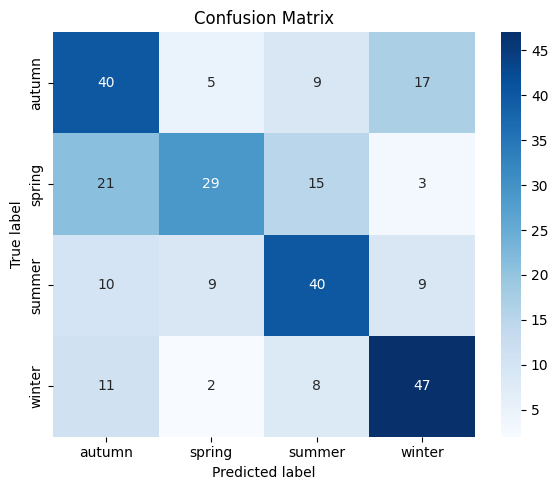

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
labels = list(label_map.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

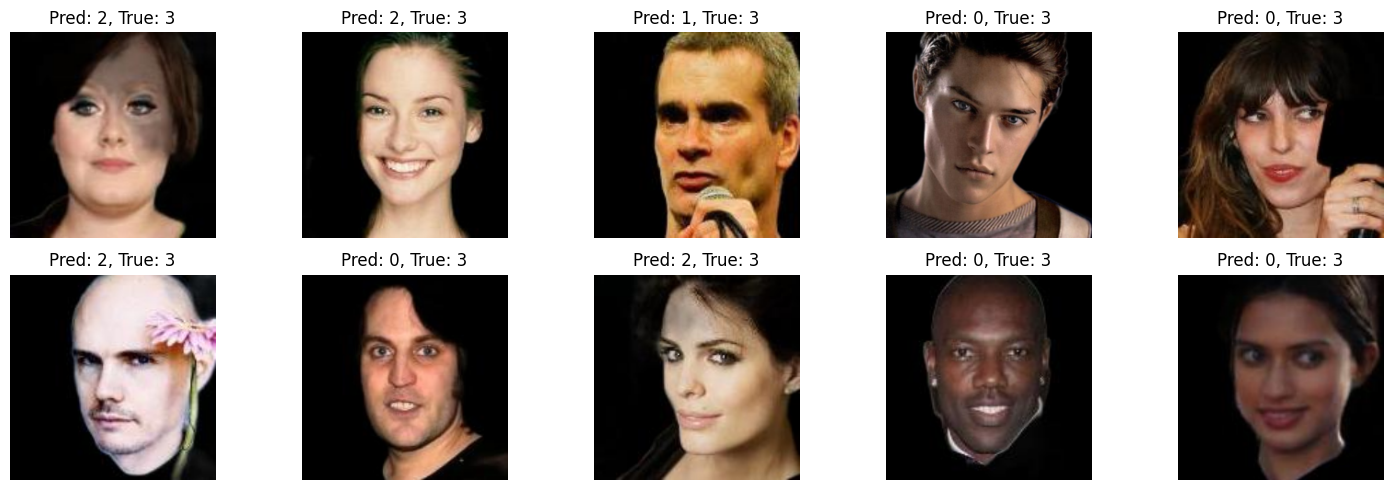

In [102]:
model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        wrong_mask = predicted != labels
        if wrong_mask.any():
            wrong_images.append(images[wrong_mask].cpu())
            wrong_preds.extend(predicted[wrong_mask].cpu().tolist())
            wrong_labels.extend(labels[wrong_mask].cpu().tolist())
if wrong_images:
    wrong_images = torch.cat(wrong_images)

    num_display = min(10, len(wrong_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_display):
        img = wrong_images[i+100].permute(1, 2, 0).numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {wrong_preds[i+100]}, True: {wrong_labels[i+100]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Error.")


In [95]:
#Saving parameters of model and model as an object

torch.save(model.state_dict(), "resnet_finetuned.pt")

import pickle

with open("resnet_finetuned.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
# How to load this model in future 
# From pt. format
from torchvision import models
import torch.nn as nn
import torch

resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 4) 
resnet.load_state_dict(torch.load("resnet_finetuned.pt"))
resnet.eval()

In [ ]:
# From pkl. format 
import pickle

with open("resnet_finetuned.pkl", "rb") as f:
    model = pickle.load(f)

model.eval()